# **Libraries**

In [ ]:
#Connexion préalable à mon Google Drive afin de charger les données
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import nltk
nltk.download('punkt')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging
import plotly.express as px

logging.disable(logging.WARNING)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install tensorflow_text


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Preparation of initial dataset**

## **Load data and select columns**

In [ ]:
ecomm= pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/Clasifiez automatiquement des biens de conso/flipkart_com-ecommerce_sample_1050.csv",low_memory=False, sep=',')

In [ ]:
ecomm.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [ ]:
ecomm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [ ]:
pd.set_option("display.max_rows", None)

In [ ]:
#Avec celle colonne nous pouvons voir l'arborescence des catégories utilisées pour les produits
ecomm['product_category_tree'][0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

## **Create a column with a label of each product**

Test de différents niveaux de label dans l'arborescence : le niveau 1 d'extraction de la catégorie, permet d'avoir une bonne catégorisation des produits, sans erreurs.

In [ ]:
##Fonction qui extrait la suite de mots située juste avant un symbole de séparation dans une chaîne de caractères donnée.
    # Args:
    # string: la chaîne de caractères d'origine
    # separator: le symbole de séparation
    
    # Returns:
    # La suite de mots située juste avant le symbole de séparation

def extract_last_word_before_separator(string, separator):
    
    words = string.split(separator)
    return words[0] if len(words) > 1 else ""

def extract_last_word_before_separator_for_column(df,column, separator):
    """
    Fonction qui extrait la suite de mots située juste avant un symbole de séparation dans chaque ligne d'une colonne donnée d'un DataFrame.
    
    Args:
    df: le DataFrame d'origine
    column_name: le nom de la colonne contenant les chaînes de caractères à traiter
    separator: le symbole de séparation
    
    Returns:
    Un nouveau DataFrame contenant une colonne supplémentaire avec la suite de mots extraite pour chaque ligne
    """
    new_column_name = column + "_last_word_before_separator"
    df[new_column_name] = df[column].apply(lambda x: extract_last_word_before_separator(x, separator))
    return df

In [ ]:

ecomm_label = extract_last_word_before_separator_for_column(ecomm,'product_category_tree',' >> ')

In [ ]:
ecomm_label.head(10)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,product_category_tree_last_word_before_separator
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...","[""Home Furnishing"
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...","[""Baby Care"
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...","[""Baby Care"
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...","[""Home Furnishing"
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...","[""Home Furnishing"
5,893aa5ed55f7cff2eccea7758d7a86bd,2015-12-04 07:25:36 +0000,http://www.flipkart.com/maserati-time-r8851116...,Maserati Time R8851116001 Analog Watch - For ...,"[""Watches >> Wrist Watches >> Maserati Time Wr...",WATEAYAHJ8CUCAYM,24400.0,24400.0,893aa5ed55f7cff2eccea7758d7a86bd.jpg,False,Maserati Time R8851116001 Analog Watch - For ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp...","[""Watches"
6,f355cc1ccb08bd0d283ed979b7ee7515,2015-12-04 07:25:36 +0000,http://www.flipkart.com/camerii-wm64-elegance-...,"Camerii WM64 Elegance Analog Watch - For Men,...","[""Watches >> Wrist Watches >> Camerii Wrist Wa...",WATE6Y6D2MZHWGBZ,1099.0,449.0,f355cc1ccb08bd0d283ed979b7ee7515.jpg,False,"Camerii WM64 Elegance Analog Watch - For Men,...",5,5,NaN,"{""product_specification""=>[{""key""=>""Chronograp...","[""Watches"
7,dd0e3470a7e6ed76fd69c2da27721041,2015-12-04 07:25:36 +0000,http://www.flipkart.com/t-star-uft-tsw-005-bk-...,T STAR UFT-TSW-005-BK-BR Analog Watch - For Boys,"[""Watches >> Wrist Watches >> T STAR Wrist Wat...",WATECFFVGFZPAD3D,999.0,399.0,dd0e3470a7e6ed76fd69c2da27721041.jpg,False,T STAR UFT-TSW-005-BK-BR Analog Watch - For B...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp...","[""Watches"
8,41384da51732c0b4df3de8f395714fbb,2015-12-04 07:25:36 +0000,http://www.flipkart.com/alfajr-wy16b-youth-dig...,"Alfajr WY16B Youth Digital W

In [ ]:
ecomm_label = ecomm.drop(columns=['product_url','product_category_tree','pid','discounted_price','is_FK_Advantage_product','product_rating','overall_rating','product_specifications'])

In [ ]:
ecomm_label.rename(columns={'product_category_tree_last_word_before_separator':'label'}, inplace=True)

In [ ]:
ecomm_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   uniq_id          1050 non-null   object 
 1   crawl_timestamp  1050 non-null   object 
 2   product_name     1050 non-null   object 
 3   retail_price     1049 non-null   float64
 4   image            1050 non-null   object 
 5   description      1050 non-null   object 
 6   brand            712 non-null    object 
 7   label            1050 non-null   object 
dtypes: float64(1), object(7)
memory usage: 65.8+ KB


In [ ]:
import re

# Définir une expression régulière pour trouver les crochets et les guillemets au début d'une chaîne de caractères
regex = r'^\[\"'

# Utiliser la méthode apply() pour appliquer l'expression régulière à chaque ligne de la colonne
ecomm_label['label'] = ecomm_label['label'].apply(lambda x: re.sub(regex, '', x))


In [ ]:
ecomm_label.head(10)

,uniq_id,crawl_timestamp,product_name,retail_price,image,description,brand,label
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,Elegance Polyester Multicolor Abstract Eyelet ...,1899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Elegance,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,Sathiyas Cotton Bath Towel,600.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,Eurospa Cotton Terry Face Towel Set,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,SANTOSH ROYAL FASHION Cotton Printed King size...,2699.0,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,Jaipur Print Cotton Floral King sized Double B...,2599.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print,Home Furnishing
5,893aa5ed55f7cff2eccea7758d7a86bd,2015-12-04 07:25:36 +0000,Maserati Time R8851116001 Analog Watch - For ...,24400.0,893aa5ed55f7cff2eccea7758d7a86bd.jpg,Maserati Time R8851116001 Analog Watch - For ...,NaN,Watches
6,f355cc1ccb08bd0d283ed979b7ee7515,2015-12-04 07:25:36 +0000,"Camerii WM64 Elegance Analog Watch - For Men,...",1099.0,f355cc1ccb08bd0d283ed979b7ee7515.jpg,"Camerii WM64 Elegance Analog Watch - For Men,...",NaN,Watches
7,dd0e3470a7e6ed76fd69c2da27721041,2015-12-04 07:25:36 +0000,T STAR UFT-TSW-005-BK-BR Analog Watch - For Boys,999.0,dd0e3470a7e6ed76fd69c2da27721041.jpg,T STAR UFT-TSW-005-BK-BR Analog Watch - For B...,NaN,Watches
8,41384da51732c0b4df3de8f395714fbb,2015-12-04 07:25:36 +0000,"Alfajr WY16B Youth Digital Watch - For Men, Boys",5495.0,41384da51732c0b4df3de8f395714fbb.jpg,"Alfajr WY16B Youth Digital Watch - For Men, B...",NaN,Watches
9,710ed5f2393a4b9e8823aa0029f71f93,2015-12-04 07:25:36 +0000,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,107750.0,710ed5f2393a4b9e8823aa0029f71f93.jpg,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,NaN,Watches


## **Explore dataset**

In [ ]:
ecomm_label.describe()

,retail_price
count,1049.000000
mean,2186.197331
std,7639.229411
min,35.000000
25%,555.000000
50%,999.000000
75%,1999.000000
max,201000.000000


### **Len of sentence insight 'description' column**

In [ ]:
longueurs = ecomm_label['description'].str.len()

In [ ]:
longueurs.describe()

count    1050.000000
mean      473.820952
std       457.910422
min       109.000000
25%       192.000000
50%       278.000000
75%       588.250000
max      3490.000000
Name: description, dtype: float64

utile pour savoir comment dimensioner des algo, comme le nombre max de token (lié à la aille de description). Ici c'est la taille de description brute voir cette longueur avec les traitements.

In [ ]:
longueurs.value_counts()

197     9
315     9
171     9
212     8
187     8
172     7
143     7
178     7
209     7
177     7
219     6
165     6
175     6
195     6
245     6
183     6
268     6
249     6
256     6
173     6
168     6
191     6
820     6
203     6
135     5
125     5
145     5
281     5
184     5
819     5
200     5
138     5
333     5
237     5
128     5
127     5
259     5
235     5
257     5
260     5
317     5
332     5
140     5
266     5
329     5
253     5
121     5
227     5
262     4
274     4
181     4
162     4
308     4
169     4
201     4
198     4
211     4
148     4
151     4
123     4
215     4
231     4
192     4
182     4
206     4
224     4
439     4
146     4
179     4
199     4
144     4
258     4
553     4
303     4
222     4
321     4
193     4
190     3
230     3
210     3
185     3
433     3
241     3
114     3
174     3
454     3
763     3
566     3
189     3
1741    3
180     3
271     3
243     3
440     3
141     3
149     3
263     3
186     3
251     3
248     3


In [ ]:
ecomm_label.loc[ecomm_label['description'].str.len() == 3490]

,uniq_id,crawl_timestamp,product_name,retail_price,image,description,brand,label
437,b6c339777814451815fe7950fd4c8536,2016-06-16 08:51:06 +0000,HomeEdge Solid Wood King Bed,25499.0,b6c339777814451815fe7950fd4c8536.jpg,Key Features of HomeEdge Solid Wood King Bed K...,HomeEdge,Beauty and Personal Care


### **Sum of products by label**

In [ ]:
label_counts = ecomm_label['label'].value_counts()

In [ ]:
ecomm_label['label'].value_counts()

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: label, dtype: int64

In [ ]:
label_data = pd.DataFrame({'label': label_counts.index, 'count': label_counts.values})

In [ ]:
fig = px.histogram(label_data, x='label', y='count', nbins=len(label_counts))
fig.update_layout(yaxis_title='somme des produits par label',xaxis_title='Labels')
fig.show()

j'ai mon graphique de nombre de points par label. 

### **Sum of label by brand**

In [ ]:
grouped_data = ecomm_label.groupby(['brand', 'label']).size().reset_index(name='count')

In [ ]:
grouped_data = ecomm_label.groupby('brand').agg({'label' : 'count'})

In [ ]:
fig = px.bar(grouped_data, x='label', color='label', barmode='group')
fig.show()

## **Cleaning column 'description'**

In [ ]:
ecomm_label['description'][10]

'Calibro SW-125 Analog-Digital Watch  - For Men, Boys\r\n                         Price: Rs. 699\r\n\t\t\t\t\r\n\t\t\tCALIBRO presents MTG Black Dial Round Watch. This is a fashionable watch from MTG that adds to your style statement. This brand is known for its usage of quality material in making appealing watches. It understands the needs of youth so well that it is able to present wide range of watches to its customers. The variety in design, style and youthful approach is very well executed by this brand. Get one and see how brilliantly it leads other brands in style, finish and everything else that matters.\r\nCALIBRO presents MTG Black Dial Round Watch. This is a fashionable watch from MTG that adds to your style statement. This brand is known for its usage of quality material in making appealing watches. It understands the needs of youth so well that it is able to present wide range of watches to its customers. The variety in design, style and youthful approach is very well exec

In [ ]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

ecomm_label['sentence_bow'] = ecomm_label['description'].apply(lambda x : transform_bow_fct(x))
ecomm_label['sentence_bow_lem'] = ecomm_label['description'].apply(lambda x : transform_bow_lem_fct(x))
ecomm_label['sentence_dl'] = ecomm_label['description'].apply(lambda x : transform_dl_fct(x))
ecomm_label.shape

(1050, 11)

In [ ]:
ecomm_label.head()

,uniq_id,crawl_timestamp,product_name,retail_price,image,description,brand,label,sentence_bow,sentence_bow_lem,sentence_dl
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,Elegance Polyester Multicolor Abstract Eyelet ...,1899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Elegance,Home Furnishing,key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,Sathiyas Cotton Bath Towel,600.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas,Baby Care,specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,Eurospa Cotton Terry Face Towel Set,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa,Baby Care,key features eurospa cotton terry face towel s...,key feature eurospa cotton terry face towel se...,key features of eurospa cotton terry face towe...
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,SANTOSH ROYAL FASHION Cotton Printed King size...,2699.0,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION,Home Furnishing,key features santosh royal fashion cotton prin...,key feature santosh royal fashion cotton print...,key features of santosh royal fashion cotton p...
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,Jaipur Print Cotton Floral King sized Double B...,2599.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print,Home Furnishing,key features jaipur print cotton floral king s...,key feature jaipur print cotton floral king si...,key features of jaipur print cotton floral kin...


In [ ]:
ecomm_label.to_csv("ecomm_label_clean.csv", index=False)

In [ ]:
ecomm_label_clean =  pd.read_csv("/content/ecomm_label_clean.csv")
print(ecomm_label_clean.shape)

ecomm_label_clean.head(1)

(1050, 11)


,uniq_id,crawl_timestamp,product_name,retail_price,image,description,brand,label,sentence_bow,sentence_bow_lem,sentence_dl
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,Elegance Polyester Multicolor Abstract Eyelet ...,1899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Elegance,Home Furnishing,key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...


# **Common preparation of threatments**

## Exploration of new dataset

In [ ]:
#Create list of label(category)
l_cat = list(set(ecomm_label_clean['label']))
print("catégories : ", l_cat)

#Variable used for the common function
y_cat_num = [(1-l_cat.index(ecomm_label_clean.iloc[i]['label'])) for i in range(len(ecomm_label_clean))]

catégories :  ['Watches', 'Home Decor & Festive Needs', 'Beauty and Personal Care', 'Kitchen & Dining', 'Baby Care', 'Computers', 'Home Furnishing']


In [ ]:
#Calculate len of sentences from columns 'sentence_bow and 'sentence_dl', previously built
ecomm_label_clean['length_bow'] = ecomm_label_clean['sentence_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", ecomm_label_clean['length_bow'].max())
print("min length bow : ", ecomm_label_clean['length_bow'].min())
ecomm_label_clean['length_bow_lem'] = ecomm_label_clean['sentence_bow_lem'].apply(lambda x : len(word_tokenize(x)))
print("max length bow_lem : ", ecomm_label_clean['length_bow_lem'].max())
print("min length bow_lem : ", ecomm_label_clean['length_bow_lem'].min())
ecomm_label_clean['length_dl'] = ecomm_label_clean['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", ecomm_label_clean['length_dl'].max())
print("min length dl : ", ecomm_label_clean['length_dl'].min())

max length bow :  379
min length bow :  12
max length bow_lem :  379
min length bow_lem :  12
max length dl :  632
min length dl :  16


In [ ]:
#Examples of  change made on 'description' 
print(ecomm_label_clean['description'][2])
print(ecomm_label_clean['sentence_bow'][2])
print(ecomm_label_clean['sentence_dl'][2])

Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. All our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. Eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prints, absorbency, softness and durability. NOTE: Our product is 100% cotton, so it is susceptible to shrinkage. Product color may vary from the picture. Size may vary by ±3% WASH CARE: Wash in cold Water, Do not Iron, Do not Bleach, Flat dry, Wash before first use. SIZE- FACE TOWEL - 23 cms X 23 cms.,Specifications of Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Bath Towel Features Material Cotton Terry Design SHUVAM General Brand Eurospa GSM 360 Type Face Towel Set Model Na

## Common Function

*Préparation à l'analyse de regroupement de données non supervisée sur les données textuelles.*

In [ ]:
import time

# Pour le calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
# La fonction utilise l'algorithme de réduction de dimensionnalité T-SNE (t-Distributed Stochastic Neighbor Embedding) 
# pour projeter les caractéristiques de chaque document dans un espace de deux dimensions. 
# Cela permet de visualiser les documents dans un espace en deux dimensions, tout en préservant les similitudes entre les documents.

    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    # la fonction utilise l'algorithme de clustering K-means pour regrouper les documents en 
    # un nombre prédéfini de clusters (déterminé par le nombre de classes dans les données originales)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    # la fonction calcule l'indice ARI (adjusted rand index) qui mesure la similarité entre 
    # les vraies étiquettes de classe et les étiquettes de classe prédites par l'algorithme de clustering
    return ARI, X_tsne, cls.labels_



# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    #Représentation des descriptions produits selon les vraies classes. Chaque point = une description et sa position
    # déterminée par sa projection TSNE 2D
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des descriptions de produits par catégorie de label')
    
    #Représentation des descriptions produits selon les clusters prédits. Chaque point = une description et sa position
    # déterminée par sa projection TSNE 2D
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des descriptions de produits par cluster')
    
    plt.show()
    print("ARI : ", ARI)


# **Features extractions with bag of word and Tf-idf**

*Méthode de comptage direct d'occurences pour chaque mot.Transformation des mots en vecteurs numériques qui représentent leur fréquence d'apparition. technique NLP qui représente un document en tant que sac de mot en ignorant complètement la structure syntaxique ou la séquence des mot dans le texte.*

## Preparation of sentences

In [ ]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=3)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=3)
#max_df=les mots qui apparaissent dans plus de 95% des documents seront ignorés.
#min_df=1 : les mots qui n'apparaissent que dans un seul document seront ignorés

feat = 'sentence_bow_lem' #variable avec nom de la colonne des données contenant les phrases à vectoriser
cv_fit = cvect.fit(ecomm_label_clean[feat]) #adapte le cvect dans la colonne 'feat'
ctf_fit = ctf.fit(ecomm_label_clean[feat])#adapte le ctf dans la colonne 'feat'

cv_transform = cvect.transform(ecomm_label_clean[feat])  #méthode transform pour créer la matrice d'occurences des mots dans le doc
ctf_transform = ctf.transform(ecomm_label_clean[feat])  #méthode transform pour créer la matrice TFidf des doc

#matrice créée pour être utilisé pour entrainer un modèle de classification 

## Exécution des modèles

In [ ]:
#Classification par bag of word
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()

#Classification par Tf iDF
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)


CountVectorizer : 
-----------------
ARI :  0.3707 time :  20.0

Tf-idf : 
--------
ARI :  0.4923 time :  21.0


***Le score ARI nous montre qu'il y a 1 bonne similarité entre les catégories réelles et les clusters, et ce, pour les deux méthodes d'extraction de features. (BOW=0.4132 et Tfidf=0.463 avec hyperparamètres min_df=2). Meilleurs résultats sur extraction de features par Tfidf -> bow=0.3707  et tfidf=0.4923  avec min_df=3. Modifie l'hyperparamètre max_df n'apporte pas de changement significatif.*** 



## Graphiques

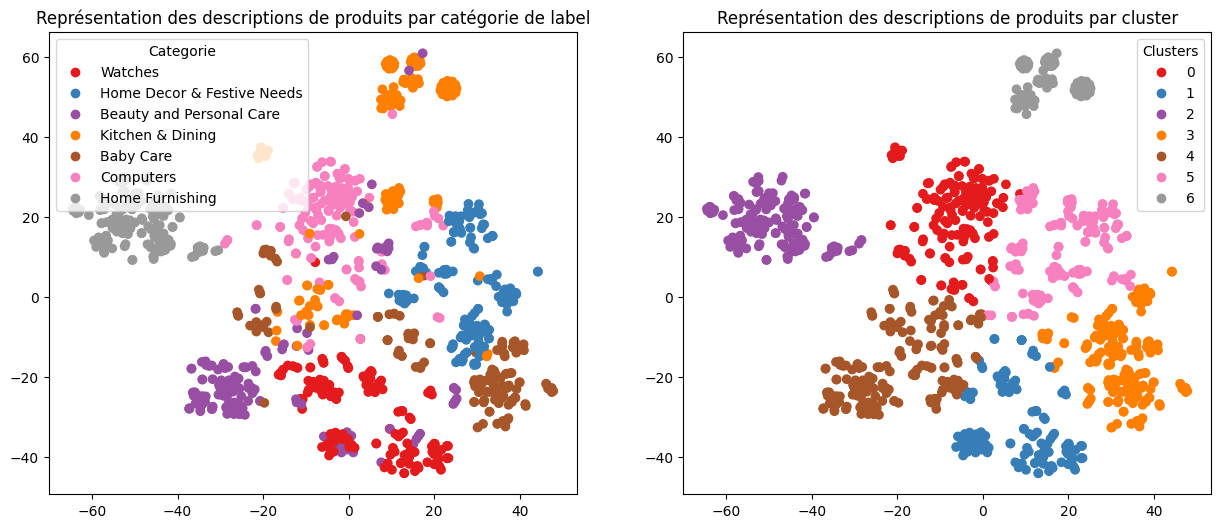

ARI :  0.4923


In [ ]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

***Avec un hyperparamètres min_df de 2 : Nous voyons des clusters distincts. Les changements que nous avont fait sur les labels avec le choix de prendre le niveau 1 sur la colonne 'arbre' permet de meilleurs résultats que lorsque l'on choisit un label plus précis. Le score ARI est passé de 0.10 pour le niveau 3 ou 2 à 0.451 ! Deuxième essai avec min_df=2 --> bow=0.4132 & tfidf=0463***

**Extraction de features** 

*BAG of WORDS* : représentation avec comptage des mots. Chaque document peut être représenter par un bag of word. un doc peut être représenté par des combinaisons de mots par par co-occurence (bigramme, trigramme etc).

*TF IDF* : terme frequency - iunverse document frequency. Pondère l'importance d'un mot dans un doc par rapport à l'ensemble du doc. 
Poids = fréquence du n-gramm x idf(ngramme = inverse de fréquence du mot dans tout le doc) Utile pour le TSNE puisque çà permet de faire des clusters de mots associés.

*Named Entity Recognition* permet de reconnaître des entités nommés (nom propre)

*Extraction des relations* : modèliser les relations entre les mots (relations familiales, relation entre ville et pays etc) a modéliser en graph

*POS tagging* permet de récupérer la famille dont appartient le mot 


# **Features extractions with Word2Vec to make a word embeddings**

*Réseau de neurones - technique de représentation d’un mot, ou un ensemble de mots, en vecteurs de dimension inférieure.Les mots qui ont des contextes similaires ont des représentations vectorielles similaires dans l'espace vectoriel.*

In [ ]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

Prendre en compte le “contexte” dans lequel le mot a été trouvé, c’est à dire les mots avec lesquels il est souvent utilisé. On appelle cette hypothèse distributional hypothesis.

Calculer les vecteurs qui représentent les mots, les méthodes word2vec utilisent des perceptrons linéaires simples avec une seule couche cachée. 

Deux méthodes d'entrainement possible : 
- Continuous bag of Words (CBOW)(entraîne le réseau de neurones pour prédire un mot en fonction de son contexte, c’est à dire les mots avant/après dans une phrase).

D'autres méthodes autres que Word2Vec:
- Skip-Gram : prédire le contexte en fonction du mot.
- gloVe
- FastText 

Des moèdles pré entrainés existent mais attention à la création de biais s'ils nont pas été entrainé sur le même type de corpus que nos textes et créé aussi un problème de généralisation.  Voici un tutoriel pour entrainer son propre modèel embedding https://radimrehurek.com/gensim/auto_examples/. 

## Création du modèle Word2Vec

In [ ]:
#Définition des variables utilisées dans le modèle Word2Vec

w2v_size=300 #chaque mot sera représenté par un vecteur de 300 dimensions

w2v_window=5 #nombre de mots qui sont pris en compte à gauche et à droite de 
# chaque mot dans le corpus pour construire le contexte dans lequel le mot apparaît.

w2v_min_count=3 #définit le nombre minimum de fois qu'un mot doit apparaître 
# dans le corpus pour être inclus dans le vocabulaire du modèle

w2v_epochs=100 #nombre d'itérations d'entraînement que le modèle Word2Vec effectue sur le corpus de textes.

maxlen = 379 # adapt to length of sentences #définit la longueur maximale de chaque phrase dans le corpus. 
# Tout texte plus long que cela sera tronqué

sentences = ecomm_label_clean['sentence_bow_lem'].to_list() #Chaque phrase est stockée sous forme de liste de mots.

sentences = [gensim.utils.simple_preprocess(text) for text in sentences] #étape de prétraitement sur les phrases, en utilisant la fonction simple_preprocess 
# de Gensim pour tokeniser les phrases et les convertir en listes de mots en minuscules.

#Package 'gensim' = This package contains functionality to transform documents (strings) into vectors, and calculate
# similarities between documents.

In [ ]:
# Création et entraînement du modèle Word2Vec sur le corpus de texte stocké dans 'sentence'

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
#crée une instance de la classe Word2Vec de Gensim, en utilisant les paramètres définis précédemment (min_count, window, vector_size, seed) 
# pour initialiser le modèle. Le paramètre workers indique le nombre de threads de traitement à utiliser pour 
# l'entraînement du modèle (ici, 1 seul thread est utilisé). indique le nombre de processus simultanés qui seront utilisés pour l'entraînement du modèle Word2Vec. 
# Dans ce cas, le nombre de threads est fixé à 1, ce qui signifie que l'entraînement du modèle ne sera effectué que sur un seul thread de traitement. (ne pourra pas être parallélisé).

w2v_model.build_vocab(sentences) #construction du vocabulaire du modèle en analysant toutes les phrases dans 'sentences'.

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)#entrainement sur le nombre d'itération spécifié plus haut

model_vectors = w2v_model.wv #extraction des vecteurs appris par le modèle

w2v_words = model_vectors.index_to_key #stovkage du vocabulaire appris sous forme de liste

print("Vocabulary size: %i" % len(w2v_words)) #taille du vocabulaire appris
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 2274
Word2Vec trained


In [ ]:
# Préparation des sentences (tokenization des sentences pour le deep learning)
#Convertir un texte brut en séquence numérique signifivatives pour les modèles NLP

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences) #adapter le tokenizer aux données d'entraînement. 
#Cela permettra d'attribuer un numéro unique à chaque mot de chaque phrase de la liste.
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
#convertir chaque phrase en une liste de nombres correspondant aux numéros de chaque mot dans le tokenizer
# pad_sequences() pour remplir ou tronquer chaque liste de nombres de manière à ce qu'elle ait la même longueur, qui est spécifiée par maxlen.                                                  
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4713


## Création de la matrice d'embedding

In [ ]:
# Création de la matrice d'embedding
# contiendra les vecteurs d'embedding pré-entraînés pour chaque mot du corpus
print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index #word_index = liste de mots préentrainés du modèle
# tokenizer pour créer un dictionnaire de mots et de leurs index dans le corpus.
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
#parcours le dictionnaire, pour chaque mot de notre modèle présent dans la liste word_index, alors la boucle extrait son vecteur d'embedding
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  0.4826
Embedding matrix: (4713, 300)


## Création du modèle d'embedding

In [ ]:
# Création du modèle
#création d'un réseau de neurones pour le traitement de texte. 
 
input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  

#utilisation d'une couche d'embedding pour présenter chaque mot en tant que vecteur, 
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)

#une couche de pooling pour agréger les vecteurs,
word_vec=GlobalAveragePooling1D()(word_embedding)  

embed_model = Model([word_input],word_vec)
embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 379)]             0         
                                                                 
 embedding (Embedding)       (None, 379, 300)          1413900   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,413,900
Trainable params: 1,413,900
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle

In [ ]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 8ms/step


(1050, 300)

In [ ]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.3286 time :  17.0


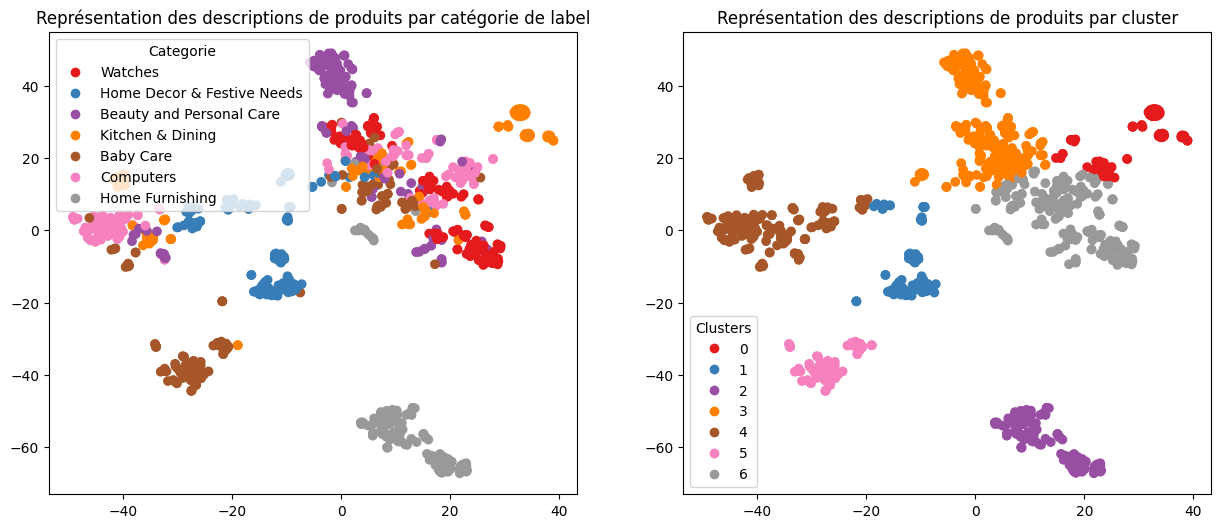

ARI :  0.3286


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

***Une bonne clusterisation mais un score ARI 0.32***

# **Features extractions with BERT**

In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning:

Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.

/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning:

Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.

/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning:

Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.



In [ ]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.12.0
2.12.0
Num GPUs Available:  0
True


## Fonctions communes

In [ ]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

  
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [ ]:
max_length = 379
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = ecomm_label_clean['sentence_dl'].to_list()

In [ ]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 16s 16s/step
temps traitement :  2164.0


In [ ]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.2929 time :  16.0


In [ ]:
ARI_bert_base_uncased = ARI_fct(features_bert)

ARI :  0.2929 time :  16.0


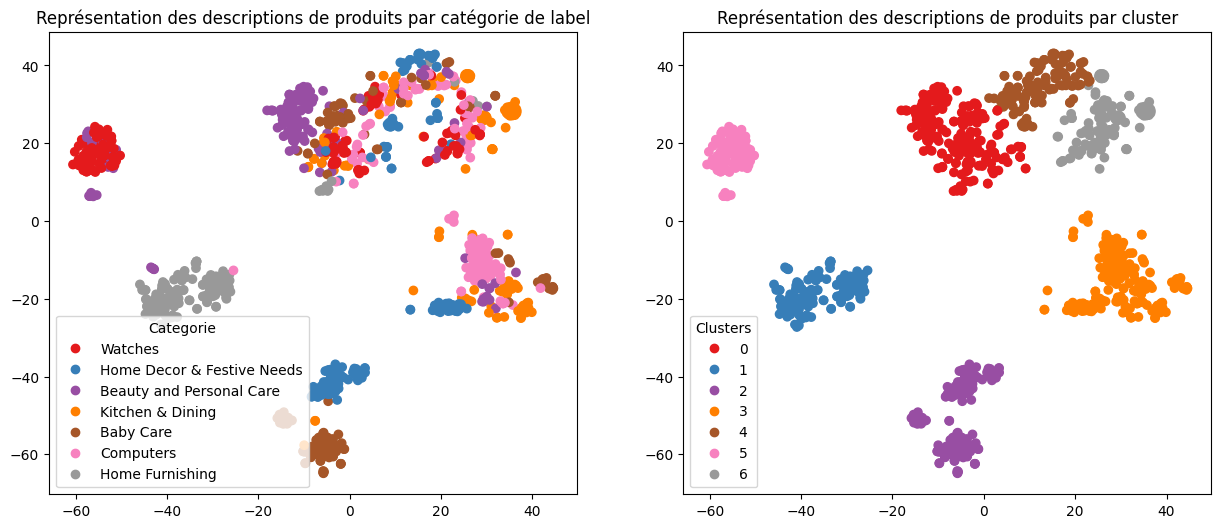

ARI :  0.2929


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### 'cardiffnlp/twitter-roberta-base-sentiment'
*Modèle pré-entraîné sur des tweets pour l'analyse de sentiment, peu adapté au contexte*

In [ ]:
max_length = 379
batch_size = 10
model_type = 'cardiffnlp/twitter-roberta-base-sentiment'
model = TFAutoModel.from_pretrained(model_type)
sentences = ecomm_label_clean['sentence_dl'].to_list()

In [ ]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 15s 15s/step
temps traitement :  2082.0


In [ ]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.1977 time :  16.0


In [ ]:
ARI_cardiffnlp = ARI_fct(features_bert)

ARI :  0.1977 time :  20.0


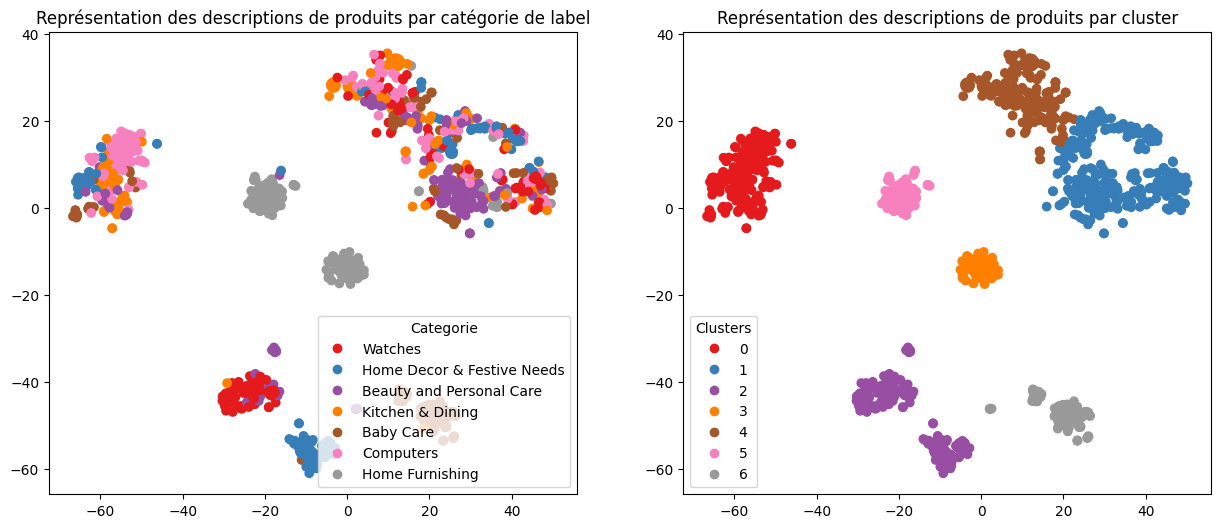

ARI :  0.1977


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## BERT hub Tensorflow

In [ ]:
import tensorflow_hub as hub
import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [ ]:
sentences = ecomm_label_clean['sentence_dl'].to_list()

In [ ]:
max_length = 379
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert_name, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  1894.0


In [ ]:
ARI, X_tsne, labels = ARI_fct(features_bert_name)

ARI :  0.2929 time :  29.0


In [ ]:
ARI_tensorflow=ARI_fct(features_bert_name)

ARI :  0.2929 time :  16.0


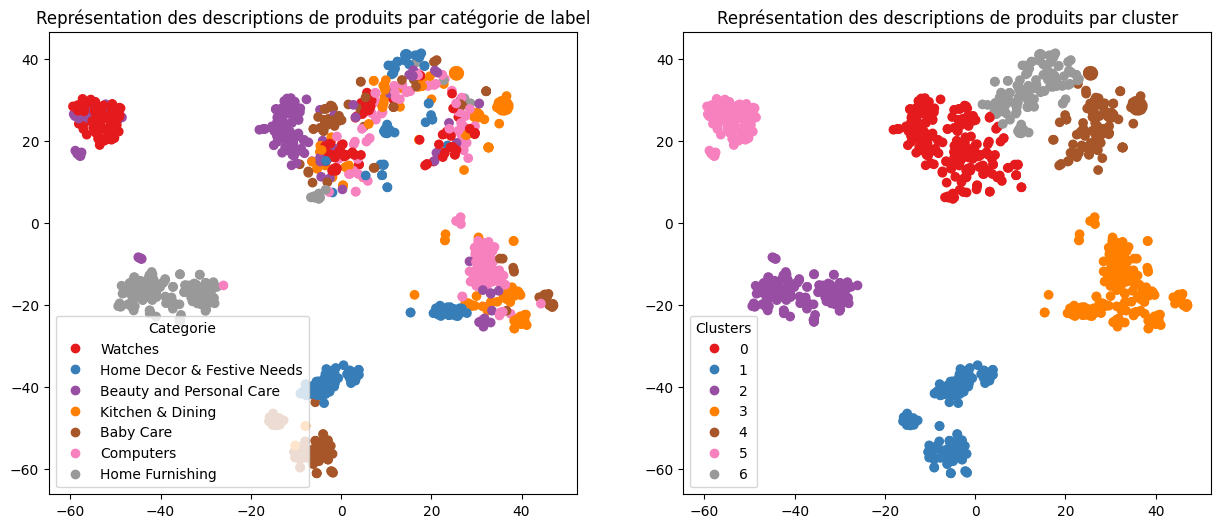

ARI :  0.2929


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# **USE - Universal Sentence Encoder**

In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [ ]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.12.0
2.12.0
Num GPUs Available:  0
True


In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [ ]:
batch_size = 10
sentences = ecomm_label_clean['sentence_dl'].to_list()

In [ ]:
features_USE = feature_USE_fct(sentences, batch_size)

In [ ]:
features_USE

array([[-0.05539605, -0.02782315,  0.01833181, ...,  0.05086442,
         0.04917974, -0.01530948],
       [-0.0512289 , -0.01898727,  0.01227693, ...,  0.03308195,
         0.0315395 ,  0.0346358 ],
       [-0.05810826,  0.02152606, -0.04410998, ...,  0.05775318,
        -0.05077325, -0.04726296],
       ...,
       [-0.04408047, -0.03755886,  0.03047283, ...,  0.01414981,
         0.05765438, -0.06278041],
       [-0.04686178, -0.03928437,  0.0489871 , ...,  0.04509434,
        -0.01900146, -0.02946299],
       [-0.05539848, -0.02439289,  0.05092698, ...,  0.04759795,
        -0.02505925, -0.01377852]], dtype=float32)

In [ ]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.4355 time :  17.0


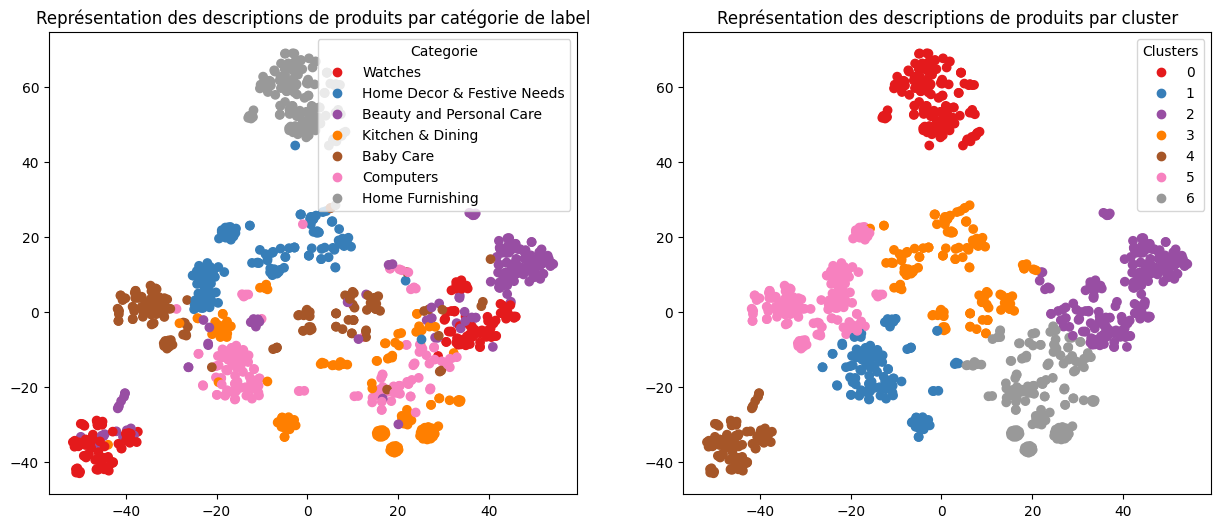

ARI :  0.4355


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# **Comparaison des résultats entre les différents modèles de classification**

In [ ]:
#créer un dictionnaire pour stocker les résultats ARI des différents modèles
résultats_ari={'Bag of Word':ARI_fct(cv_transform),'Tf-iDF':ARI_fct(ctf_transform), 'Word2vec':ARI_fct(embeddings),'BERT bert-base-uncased':ARI_bert_base_uncased[0],'BERT Cardiffnlp':ARI_cardiffnlp[0],'BERT Tensorflow':ARI_tensorflow[0],'USE':ARI_fct(features_USE)} 

ARI :  0.3707 time :  23.0
ARI :  0.4923 time :  18.0
ARI :  0.3286 time :  21.0
ARI :  0.4355 time :  18.0


In [ ]:
compar_ari = pd.DataFrame.from_dict(résultats_ari)
compar_ari= compar_ari.drop([1,2], axis=0)
compar_ari

,Bag of Word,Tf-iDF,Word2vec,BERT bert-base-uncased,BERT Cardiffnlp,BERT Tensorflow,USE
0,0.3707,0.4923,0.3286,0.2929,0.1977,0.2929,0.4355


**Les modèles BOW, TfiDF et USE ont les meilleurs scores ARI.**

# **Classification**



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = features_USE
y = ecomm_label_clean['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=36)

model = LogisticRegression().fit(X_train,y_train)

X_test_df = pd.DataFrame(X_test)

model.predict(X_test_df.iloc[:5,:])



array(['Home Decor & Festive Needs', 'Home Decor & Festive Needs',
       'Home Decor & Festive Needs', 'Watches',
       'Beauty and Personal Care'], dtype=object)

In [ ]:
print("\nScore for the Train dataset :", model.score(X_train, y_train))
print("Score for the Test dataset :", model.score(X_test, y_test))


Score for the Train dataset : 0.9453621346886912
Score for the Test dataset : 0.9049429657794676


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = features_USE
y = y_cat_num

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=36)

model = LogisticRegression().fit(X_train,y_train)

X_test_df = pd.DataFrame(X_test)

model.predict(X_test_df.iloc[:5,:])



array([ 0,  0,  0,  1, -1])

In [ ]:
print("\nScore for the Train dataset :", model.score(X_train, y_train))
print("Score for the Test dataset :", model.score(X_test, y_test))


Score for the Train dataset : 0.9453621346886912
Score for the Test dataset : 0.9049429657794676
